In [1]:
import sys
sys.path.append("../") 

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, data_home='../data',cache=True,as_frame=False)
X=X/255.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

In [4]:
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon
from hamiltonian import utils

N,D=X_train.shape
K=len(np.unique(y_train))

y_train=utils.one_hot(y_train,K)
y_test=utils.one_hot(y_test,K)

model_ctx=mx.cpu()
par={'weights':nd.random_normal(shape=(D,K),ctx=model_ctx),'bias':nd.random_normal(shape=K,ctx=model_ctx)}
hyper={'alpha':nd.array(1.0, ctx=model_ctx)}

In [5]:
from hamiltonian.inference.sgd import sgd
from hamiltonian.models.softmax import softmax

model=softmax(hyper,ctx=model_ctx)
inference=sgd(model,par,ctx=model_ctx)

In [6]:
for param in par:
    par[param].attach_grad()

In [7]:
X_batch=nd.array(X_train[:32,:],ctx=model_ctx)
y_batch=nd.array(y_train[:32,:],ctx=model_ctx)

In [8]:
with autograd.record():
    y_hat = model.forward(par,X_train=X_batch)
    loss = model.cross_entropy(y_hat, y_batch)
loss.backward()

In [9]:
for param in par:
    print(par[param].grad)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
<NDArray 784x10 @cpu(0)>

[-1.7324317e-01 -6.6803523e-06 -9.7723923e-06 -2.3508571e-02
 -5.4245291e-04 -2.3309406e-02 -1.4359161e-04 -3.0076364e-02
  2.5084201e-01 -1.9749993e-06]
<NDArray 10 @cpu(0)>


In [10]:
grad_p=model.grad(par,X_train=X_batch,y_train=y_batch)

In [11]:
for grad in grad_p:
    print(grad_p[grad])


[[-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 ...
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]]
<NDArray 784x10 @cpu(0)>

[-0.24538554 -2.9999518  -5.99984    -2.9655387  -0.65932274 -2.9778652
 -1.9982483  -2.9723396  26.818478   -5.9999866 ]
<NDArray 10 @cpu(0)>


In [12]:
par,loss=inference.fit(epochs=100,batch_size=128,gamma=0.9,X_train=X_train,y_train=y_train,verbose=True)

  1%|          | 1/100 [00:00<00:44,  2.21it/s]

loss: 1.9346


 11%|█         | 11/100 [00:03<00:30,  2.96it/s]

loss: 1.7099


 21%|██        | 21/100 [00:07<00:26,  2.98it/s]

loss: 1.6962


 31%|███       | 31/100 [00:10<00:23,  2.97it/s]

loss: 1.5929


 41%|████      | 41/100 [00:13<00:19,  2.97it/s]

loss: 1.5816


 51%|█████     | 51/100 [00:17<00:16,  2.94it/s]

loss: 1.5761


 61%|██████    | 61/100 [00:20<00:13,  2.93it/s]

loss: 1.5738


 71%|███████   | 71/100 [00:24<00:09,  2.97it/s]

loss: 1.5726


 81%|████████  | 81/100 [00:27<00:06,  2.96it/s]

loss: 1.5713


 91%|█████████ | 91/100 [00:30<00:03,  2.97it/s]

loss: 1.5698


100%|██████████| 100/100 [00:33<00:00,  2.95it/s]


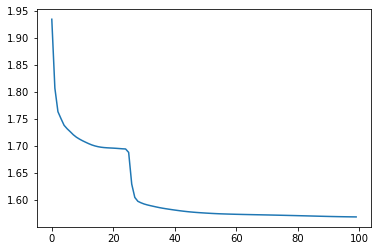

In [13]:
import matplotlib.pyplot as plt

plt.plot(loss)
plt.show()

In [14]:
y_pred=model.predict(par,nd.array(X_test,ctx=model_ctx))

In [15]:
y_pred[:10]


[4. 8. 2. 4. 1. 4. 7. 8. 5. 2.]
<NDArray 10 @cpu(0)>

In [16]:
y_test.argmax(axis=1)

array([9, 8, 2, ..., 3, 4, 3])